## Notebook Overview
- Prepare the joint text/numeric feature matrix and establish baseline MLP performance.
- Sweep decision thresholds on test predictions to study sensitivity-specificity trade-offs.
- Evaluate random over-sampling, under-sampling, and combined resampling strategies.
- Train a cost-sensitive MLP with class weights and compare calibration outcomes.
- Quantify predictive uncertainty via Monte Carlo dropout, cross-validation, and ECE analyses.


In [ ]:
from helper_functions.notebook_utils import MetricsCallback, binary_expected_calibration_error
from helper_functions.testing import encode_and_split


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from keras.optimizers import Adam

import keras.backend as K

from helper_functions.nn import create_nn
from helper_functions.nn_training import train_model
from helper_functions.plotting import roc_plot, confusion_matrix_display

ImportError: cannot import name 'parse_version' from 'sklearn.utils' (/Users/aidanlicoppe/miniconda3/lib/python3.10/site-packages/sklearn/utils/__init__.py)

# Preparing Data

In [2]:
merged_df = pd.read_csv('combined_data.csv')
merged_df.drop(columns=['Unnamed: 0'], inplace=True)

frequent_races = ['WHITE', 'BLACK', 'HISPANIC', 'ASIAN']

# Update 'disposition' column
conditions = (merged_df['disposition'] == 'ADMITTED') | (merged_df['disposition'] == 'TRANSFER')
merged_df.loc[conditions, 'disposition'] = 'A'
merged_df.loc[~conditions, 'disposition'] = 'NA'

# Update 'race' column
merged_df.loc[~merged_df['race'].isin(frequent_races), 'race'] = 'OTHER'

columns = merged_df.columns
for column in columns[5:13]:
    scaler = MinMaxScaler()
    values = merged_df[column].values.reshape(-1, 1)
    merged_df[column] = scaler.fit_transform(values)
    
copy = merged_df.copy()

categorical_columns = ['gender', 'race', 'arrival_transport']
numeric_values = copy[columns[5:13]].values
categorical_values = copy[categorical_columns]

encoder = OneHotEncoder()

# Fit the OneHotEncoder with the categorical values
encoder.fit(categorical_values)

categorical_values = encoder.transform(categorical_values).toarray()

X_num_cat = np.concatenate((numeric_values, categorical_values), axis=1)

disposition_column = merged_df['disposition'].values

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform the 'disposition' column
Y_encoded = label_encoder.fit_transform(disposition_column)
Y = (1 - Y_encoded)

text = merged_df['chiefcomplaint'].values

# Combining text data with numerical data for training and testing
string_array_reshaped = text.reshape(-1, 1)
X_combined = np.concatenate((X_num_cat, string_array_reshaped), axis=1)

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X_combined, Y, test_size=0.2, random_state=42)

# Baseline

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X_combined, Y, test_size=0.2, random_state=42)

X_train_num, X_test_num, X_train_encoded, X_test_encoded = encode_and_split(X_train, X_test)

In [7]:
model_org = create_nn([64, 32], [32], X_train_encoded.shape[1], X_train_num.shape[1])

metrics_callback = MetricsCallback(X_test_num, X_test_encoded, Y_test)

model_org = train_model(model_org, 
                     [X_train_num, X_train_encoded], 
                     Y_train,
                     callback=metrics_callback, 
                     epochs=5)

Epoch 1/5


2024-04-01 19:32:05.559794: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2352/2352 [==============================] - 1s 412us/step
Evaluation on Test Set:
 - Sensitivity: 0.7170 - Specificity: 0.7780 - Accuracy: 0.7552 - AUC: 0.8338
9406/9406 [==============================] - 9s 885us/step - loss: 0.4900 - accuracy: 0.7562
Epoch 2/5
2352/2352 [==============================] - 1s 418us/step
Evaluation on Test Set:
 - Sensitivity: 0.6448 - Specificity: 0.8390 - Accuracy: 0.7662 - AUC: 0.8366
9406/9406 [==============================] - 8s 821us/step - loss: 0.4760 - accuracy: 0.7646
Epoch 3/5
2352/2352 [==============================] - 1s 402us/step
Evaluation on Test Set:
 - Sensitivity: 0.6267 - Specificity: 0.8518 - Accuracy: 0.7674 - AUC: 0.8380
9406/9406 [==============================] - 8s 812us/step - loss: 0.4716 - accuracy: 0.7677
Epoch 4/5
2352/2352 [==============================] - 1s 390us/step
Evaluation on Test Set:
 - Sensitivity: 0.6478 - Specificity: 0.8398 - Accuracy: 0.7679 - AUC: 0.8386
9406/9406 [==============================] - 8s

2352/2352 [==============================] - 1s 393us/step


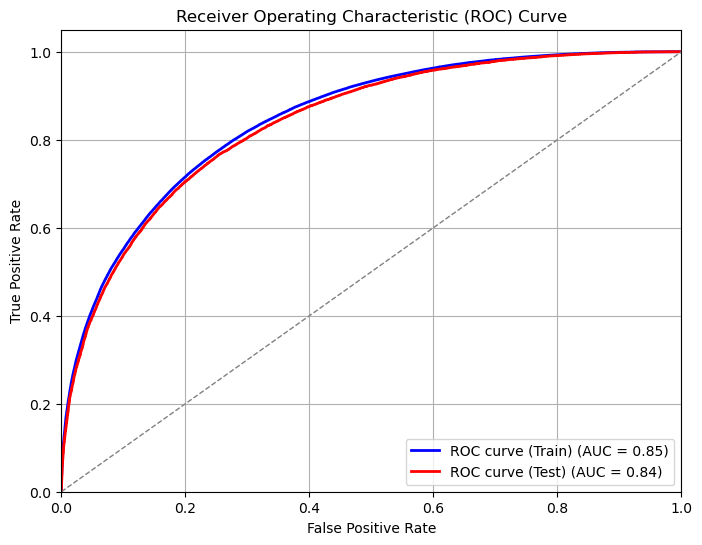

In [8]:
fpr_train, tpr_train, roc_auc_train = roc_plot(model_org, X_train_num, X_train_encoded, Y_train)
fpr_test, tpr_test, roc_auc_test = roc_plot(model_org, X_test_num, X_test_encoded, Y_test)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (Train) (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='ROC curve (Test) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Now let's test the baseline model with varying thresholds for classification, and evaluate on the test set:

2352/2352 [==============================] - 1s 399us/step

 Baseline Model (Threshold=0.5)
Accuracy: 76.67%
Sensitivity: 0.57
Specificity: 0.884
AUC: 0.8392

 Baseline Model (Threshold=0.4)
Accuracy: 76.38%
Sensitivity: 0.708
Specificity: 0.797
AUC: 0.8392

 Baseline Model (Threshold=0.3)
Accuracy: 73.11%
Sensitivity: 0.825
Specificity: 0.675
AUC: 0.8392

 Baseline Model (Threshold=0.2)
Accuracy: 67.04%
Sensitivity: 0.913
Specificity: 0.525
AUC: 0.8392

 Baseline Model (Threshold=0.1)
Accuracy: 56.21%
Sensitivity: 0.975
Specificity: 0.314
AUC: 0.8392


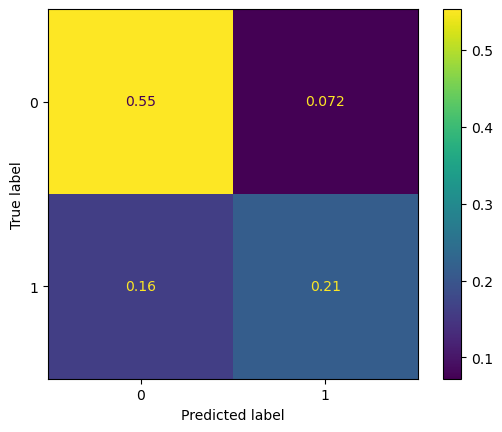

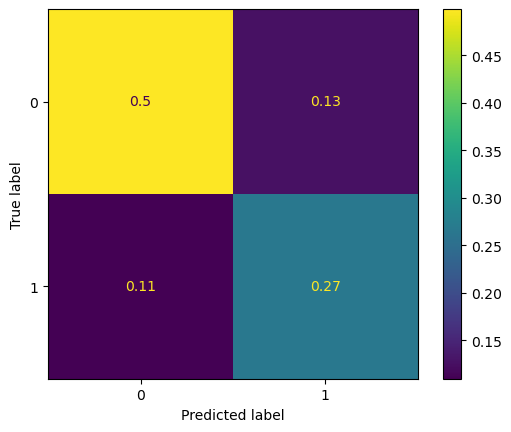

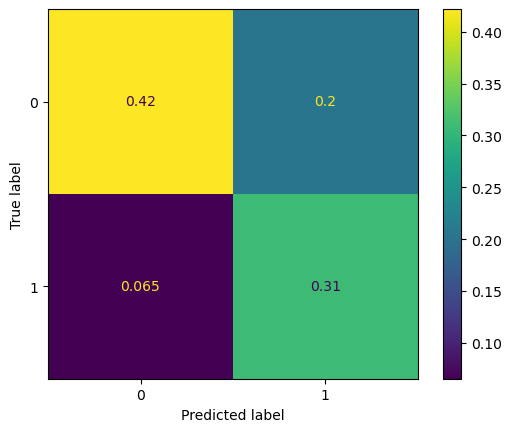

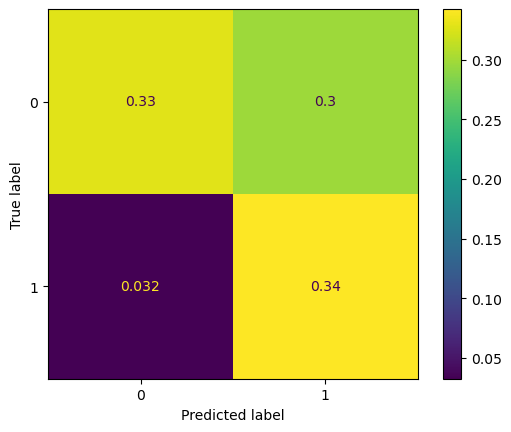

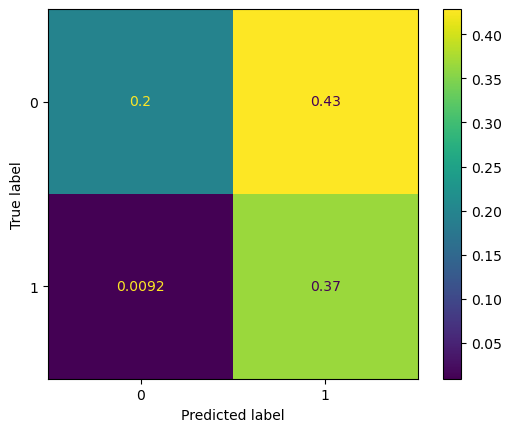

In [9]:
thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]
y_pred = model_org.predict([X_test_num, X_test_encoded])

for threshold in thresholds:
    confusion_matrix_display(y_pred, Y_test, f'Baseline Model (Threshold={threshold})', threshold=threshold)

# Random Over Sampling of Minority Class

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X_combined, Y, test_size=0.2, random_state=42)

ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, Y_train_resampled = ros.fit_resample(X_train, Y_train)

X_train_num, X_test_num, X_train_encoded, X_test_encoded = encode_and_split(X_train_resampled, X_test)

In [11]:
model_ros = create_nn([64, 32], [32], X_train_encoded.shape[1], X_train_num.shape[1])

metrics_callback = MetricsCallback(X_test_num, X_test_encoded, Y_test)

model_ros = train_model(model_ros, 
                     [X_train_num, X_train_encoded], 
                     Y_train_resampled,
                     callback=metrics_callback, 
                     epochs=5)

Epoch 1/5
2352/2352 [==============================] - 1s 398us/step
Evaluation on Test Set:
 - Sensitivity: 0.7648 - Specificity: 0.7386 - Accuracy: 0.7484 - AUC: 0.8355
11823/11823 [==============================] - 10s 853us/step - loss: 0.5046 - accuracy: 0.7466
Epoch 2/5
2352/2352 [==============================] - 1s 420us/step
Evaluation on Test Set:
 - Sensitivity: 0.7451 - Specificity: 0.7616 - Accuracy: 0.7554 - AUC: 0.8374
11823/11823 [==============================] - 10s 837us/step - loss: 0.4926 - accuracy: 0.7543
Epoch 3/5
2352/2352 [==============================] - 1s 413us/step
Evaluation on Test Set:
 - Sensitivity: 0.7164 - Specificity: 0.7875 - Accuracy: 0.7608 - AUC: 0.8380
11823/11823 [==============================] - 10s 837us/step - loss: 0.4879 - accuracy: 0.7574
Epoch 4/5
2352/2352 [==============================] - 1s 407us/step
Evaluation on Test Set:
 - Sensitivity: 0.7506 - Specificity: 0.7596 - Accuracy: 0.7562 - AUC: 0.8386
11823/11823 [===============

2352/2352 [==============================] - 1s 414us/step

 Random Oversampling Model:
Accuracy: 74.22%
Sensitivity: 0.799
Specificity: 0.708
AUC: 0.8387


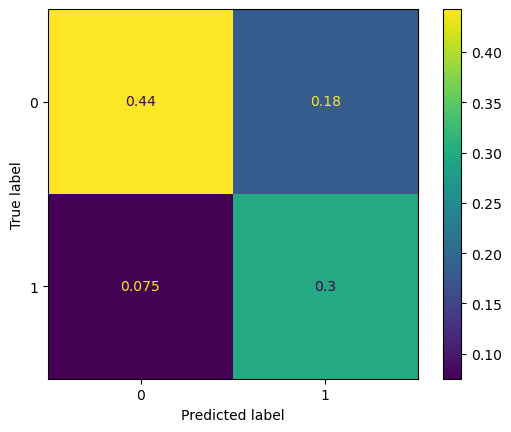

In [12]:
y_pred = model_ros.predict([X_test_num, X_test_encoded])
confusion_matrix_display(y_pred, Y_test, 'Random Oversampling Model:')

# Random Under Sampling of Majority Class

In [13]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled2, Y_train_resampled2 = rus.fit_resample(X_train, Y_train)

X_train_num2, X_test_num2, X_train_encoded2, X_test_encoded2 = encode_and_split(X_train_resampled2, X_test)

In [14]:
model_rus = create_nn([64, 32], [32], X_train_encoded2.shape[1], X_train_num2.shape[1])

metrics_callback = MetricsCallback(X_test_num2, X_test_encoded2, Y_test)

model_rus = train_model(model_rus, 
                     [X_train_num2, X_train_encoded2], 
                     Y_train_resampled2,
                     callback=metrics_callback, 
                     epochs=5)

Epoch 1/5
2352/2352 [==============================] - 1s 401us/step
Evaluation on Test Set:
 - Sensitivity: 0.7037 - Specificity: 0.7899 - Accuracy: 0.7576 - AUC: 0.8331
6988/6988 [==============================] - 7s 933us/step - loss: 0.5108 - accuracy: 0.7424
Epoch 2/5
2352/2352 [==============================] - 1s 392us/step
Evaluation on Test Set:
 - Sensitivity: 0.7976 - Specificity: 0.7009 - Accuracy: 0.7371 - AUC: 0.8350
6988/6988 [==============================] - 6s 836us/step - loss: 0.4978 - accuracy: 0.7507
Epoch 3/5
2352/2352 [==============================] - 1s 401us/step
Evaluation on Test Set:
 - Sensitivity: 0.7739 - Specificity: 0.7309 - Accuracy: 0.7470 - AUC: 0.8363
6988/6988 [==============================] - 6s 842us/step - loss: 0.4933 - accuracy: 0.7529
Epoch 4/5
2352/2352 [==============================] - 1s 453us/step
Evaluation on Test Set:
 - Sensitivity: 0.7561 - Specificity: 0.7512 - Accuracy: 0.7530 - AUC: 0.8371
6988/6988 [==========================

2352/2352 [==============================] - 1s 392us/step

 Random Undersampling Model:
Accuracy: 75.54%
Sensitivity: 0.747
Specificity: 0.76
AUC: 0.8372


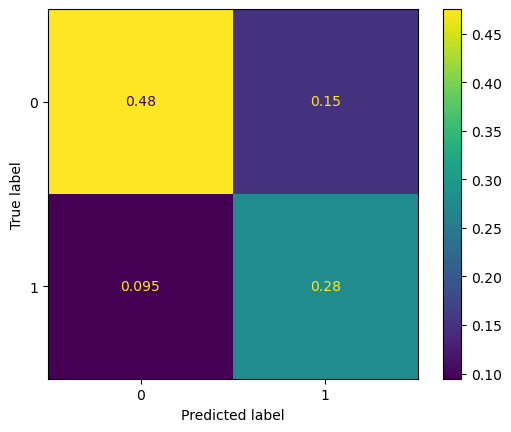

In [15]:
y_pred = model_rus.predict([X_test_num2, X_test_encoded2])
confusion_matrix_display(y_pred, Y_test, 'Random Undersampling Model:')

# Combination of ROS and RUS

In [16]:
# Define the resampling pipeline
resampling_pipeline = Pipeline([
    ('over_sampler', RandomOverSampler(sampling_strategy=0.8)),  # Adjust the sampling strategy as needed
    ('under_sampler', RandomUnderSampler(sampling_strategy=1.0))   # Adjust the sampling strategy as needed
])

# Fit and apply the resampling pipeline to your training data
X_train_resampled, Y_train_resampled = resampling_pipeline.fit_resample(X_train, Y_train)

X_train_num, X_test_num, X_train_encoded, X_test_encoded = encode_and_split(X_train_resampled, X_test)

In [17]:
model_comb = create_nn([64, 32], [32], X_train_encoded.shape[1], X_train_num.shape[1])

metrics_callback = MetricsCallback(X_test_num, X_test_encoded, Y_test)

model_comb = train_model(model_comb, 
                     [X_train_num, X_train_encoded], 
                     Y_train_resampled,
                     callback=metrics_callback, 
                     epochs=5)

Epoch 1/5
2352/2352 [==============================] - 1s 420us/step
Evaluation on Test Set:
 - Sensitivity: 0.7945 - Specificity: 0.7026 - Accuracy: 0.7370 - AUC: 0.8321
9459/9459 [==============================] - 8s 861us/step - loss: 0.5081 - accuracy: 0.7442
Epoch 2/5
2352/2352 [==============================] - 1s 406us/step
Evaluation on Test Set:
 - Sensitivity: 0.7498 - Specificity: 0.7557 - Accuracy: 0.7535 - AUC: 0.8366
9459/9459 [==============================] - 8s 865us/step - loss: 0.4957 - accuracy: 0.7523
Epoch 3/5
2352/2352 [==============================] - 1s 395us/step
Evaluation on Test Set:
 - Sensitivity: 0.7702 - Specificity: 0.7391 - Accuracy: 0.7508 - AUC: 0.8380
9459/9459 [==============================] - 8s 867us/step - loss: 0.4905 - accuracy: 0.7559
Epoch 4/5
2352/2352 [==============================] - 1s 422us/step
Evaluation on Test Set:
 - Sensitivity: 0.7723 - Specificity: 0.7378 - Accuracy: 0.7507 - AUC: 0.8386
9459/9459 [==========================

   1/2352 [..............................] - ETA: 36s

2352/2352 [==============================] - 1s 405us/step

 Combined ROS & RUS Model:
Accuracy: 75.86%
Sensitivity: 0.735
Specificity: 0.773
AUC: 0.8386


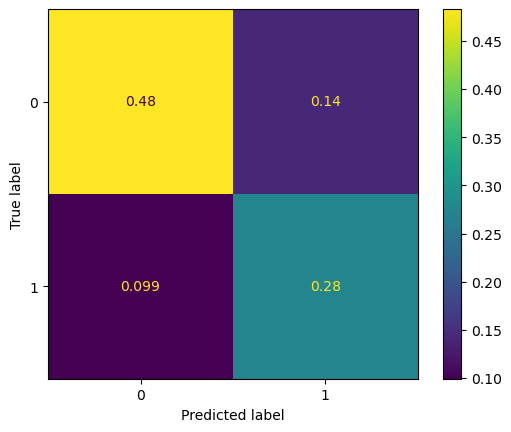

In [18]:
y_pred = model_comb.predict([X_test_num, X_test_encoded])
confusion_matrix_display(y_pred, Y_test, 'Combined ROS & RUS Model:')

# Cost-Sensitive Learning

In [74]:
X_train, X_test, Y_train, Y_test = train_test_split(X_combined, Y, test_size=0.2, random_state=42)

X_train_num, X_test_num, X_train_encoded, X_test_encoded = encode_and_split(X_train, X_test)

In [75]:
# Determine class weights
neg = Y_train[Y_train==0].shape[0]
pos = Y_train[Y_train==1].shape[0]
total = Y_train.shape[0]

w0 = (1/pos)*(total/2)
w1 = (1/neg)*(total/2)

print('w0:', w0)
print('w1:', w1)

w0: 1.3459986941082818
w1: 0.7955087303810918


In [76]:
def weighted_binary_cross_entropy(y_true, y_pred):
    w0 = 1.346
    w1 = 0.7955
    y_true = tf.cast(y_true, y_pred.dtype) 
    # Compute the binary cross-entropy loss with provided class weights
    loss = - (w0 * y_true * tf.math.log(y_pred + 1e-10) + w1 * (1 - y_true) * tf.math.log(1 - y_pred + 1e-10))
    return tf.reduce_mean(loss, axis=-1)

In [77]:
model_cost = create_nn([64, 32], [32], X_train_encoded.shape[1], X_train_num.shape[1])

metrics_callback = MetricsCallback(X_test_num, X_test_encoded, Y_test)

model_cost = train_model(model_cost, 
                     [X_train_num, X_train_encoded], 
                     Y_train,
                     callback=metrics_callback, 
                     loss=weighted_binary_cross_entropy,
                     epochs=10)



Epoch 1/10
2352/2352 [==============================] - 1s 420us/step
Evaluation on Test Set:
 - Sensitivity: 0.7642 - Specificity: 0.7374 - Accuracy: 0.7475 - AUC: 0.8342
9406/9406 [==============================] - 9s 881us/step - loss: 0.5094 - accuracy: 0.7428
Epoch 2/10
2352/2352 [==============================] - 1s 389us/step
Evaluation on Test Set:
 - Sensitivity: 0.7417 - Specificity: 0.7661 - Accuracy: 0.7569 - AUC: 0.8371
9406/9406 [==============================] - 8s 798us/step - loss: 0.4965 - accuracy: 0.7496
Epoch 3/10
2352/2352 [==============================] - 1s 393us/step
Evaluation on Test Set:
 - Sensitivity: 0.7111 - Specificity: 0.7935 - Accuracy: 0.7626 - AUC: 0.8384
9406/9406 [==============================] - 7s 795us/step - loss: 0.4921 - accuracy: 0.7512
Epoch 4/10
2352/2352 [==============================] - 1s 414us/step
Evaluation on Test Set:
 - Sensitivity: 0.7864 - Specificity: 0.7268 - Accuracy: 0.7491 - AUC: 0.8397
9406/9406 [======================

2352/2352 [==============================] - 1s 429us/step

 Cost-Sensitive Model:
Accuracy: 75.2%
Sensitivity: 0.772
Specificity: 0.74
AUC: 0.839


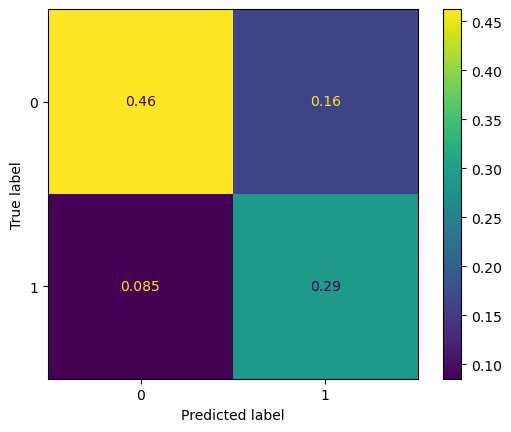

In [78]:
y_pred = model_cost.predict([X_test_num, X_test_encoded])
confusion_matrix_display(y_pred, Y_test, 'Cost-Sensitive Model:')

# Assessing Uncertainty

In [71]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from helper_functions.testing import cross_validate

In [72]:
def predict(model, x, samples=100):
    yhat_arr = []

    for t in range(samples):
        yhat = model(x, training=True)
        yhat_arr.append(yhat)

    yhat_arr = np.stack(yhat_arr, axis=-1)
    return np.squeeze(yhat_arr)

def evaluate_models(models, test_data, test_labels, mc_dropout = False):
    y_pred_concatenated = []
    y_pred_var = []
    y_test_concatenated = []

    for model, X_test, y_test in zip(models, test_data, test_labels):

        if mc_dropout:
            y_pred_arr = predict(model, X_test)
            yhat_mean = np.mean(y_pred_arr, axis=1)
            yhat_var = np.var(y_pred_arr, axis=1)
            y_pred_var.append(yhat_var)
            
        else:
            yhat_mean = model.predict(X_test)

        # Concatenate yhat_mean predictions and corresponding test labels
        y_pred_concatenated.append(yhat_mean)
        y_test_concatenated.append(y_test)

    return y_pred_concatenated, y_test_concatenated, y_pred_var

### Performance with 5-Fold Cross-Validation

In [60]:
dropouts = [0.1, 0.2, 0.3, 0.4, 0.5]
mean_accuracies = np.zeros(len(dropouts),)
mean_sensitivities = np.zeros(len(dropouts),)
mean_specificities = np.zeros(len(dropouts),)
mean_aucs = np.zeros(len(dropouts),)

for i in range(len(dropouts)):
    print(f'Iteration {i+1}')
    models_dropout, test_data_dropout, test_labels_dropout = cross_validate(X_combined, 
                                                    Y,
                                                    num_folds=5,
                                                    epochs=5,
                                                    batch_size=32,
                                                    loss=weighted_binary_cross_entropy,
                                                    dropout=dropouts[i],
                                                    )

    y_pred_list_dr, y_test_list_dr, yvar_list_dr = evaluate_models(models_dropout, test_data_dropout, test_labels_dropout, mc_dropout=True)

    accuracies_ind = np.zeros(len(y_pred_list_dr),)
    sensitivities_ind = np.zeros(len(y_pred_list_dr),)
    specificities_ind = np.zeros(len(y_pred_list_dr),)
    aucs_ind = np.zeros(len(y_pred_list_dr),)

    for j in range(len(y_pred_list_dr)):
        
        accuracies_ind[j] = accuracy_score(y_test_list_dr[j], (y_pred_list_dr[j] > 0.5).astype(int))

        tn, fp, fn, tp = confusion_matrix(y_test_list_dr[j], (y_pred_list_dr[j] > 0.5).astype(int)).ravel()

        sensitivities_ind[j] = tp / (tp + fn)
        specificities_ind[j] = tn / (tn + fp)

        # Calculate AUC
        aucs_ind[j] = roc_auc_score(y_test_list_dr[j], y_pred_list_dr[j])


    mean_accuracies[i] = np.mean(accuracies_ind)
    mean_sensitivities[i] = np.mean(sensitivities_ind)
    mean_specificities[i] = np.mean(specificities_ind)
    mean_aucs[i] = np.mean(aucs_ind)

Iteration 1
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Iteration 2
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Iteration 3
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Iteration 4
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Iteration 5
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


In [62]:
for i in range(len(dropouts)):
    print(f'Dropout = {dropouts[i]}')
    print(f'- Mean Accuracy: {round(mean_accuracies[i]*100, 2)}%')
    print(f'- Mean Sensitivity: {round(mean_sensitivities[i], 4)}')
    print(f'- Mean Specificity: {round(mean_specificities[i], 4)}')
    print(f'- Mean AUC: {round(mean_aucs[i], 4)}')

Dropout = 0.1
- Mean Accuracy: 74.95%
- Mean Sensitivity: 0.7601
- Mean Specificity: 0.7433
- Mean AUC: 0.8362
Dropout = 0.2
- Mean Accuracy: 74.52%
- Mean Sensitivity: 0.777
- Mean Specificity: 0.7263
- Mean AUC: 0.8354
Dropout = 0.3
- Mean Accuracy: 74.67%
- Mean Sensitivity: 0.7686
- Mean Specificity: 0.7337
- Mean AUC: 0.835
Dropout = 0.4
- Mean Accuracy: 74.42%
- Mean Sensitivity: 0.7748
- Mean Specificity: 0.7261
- Mean AUC: 0.8343
Dropout = 0.5
- Mean Accuracy: 74.6%
- Mean Sensitivity: 0.7626
- Mean Specificity: 0.7361
- Mean AUC: 0.8333


### 5-Fold Cross Validation on Base Model

In [63]:
models_reg, test_data_reg, test_labels_reg = cross_validate(X_combined, 
                                                Y,
                                                num_folds=5,
                                                epochs=5,
                                                batch_size=32,
                                                loss=weighted_binary_cross_entropy,
                                                )

y_pred_list_reg, y_test_list_reg, _ = evaluate_models(models_reg, test_data_reg, test_labels_reg, mc_dropout=False)

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
2352/2352 [==============================] - 1s 359us/step


In [64]:
accuracies_ind = np.zeros(len(y_pred_list_reg),)
sensitivities_ind = np.zeros(len(y_pred_list_reg),)
specificities_ind = np.zeros(len(y_pred_list_reg),)
aucs_ind = np.zeros(len(y_pred_list_reg),)

for j in range(len(y_pred_list_reg)):
    
    accuracies_ind[j] = accuracy_score(y_test_list_reg[j], (y_pred_list_reg[j] > 0.5).astype(int))

    tn, fp, fn, tp = confusion_matrix(y_test_list_reg[j], (y_pred_list_reg[j] > 0.5).astype(int)).ravel()

    sensitivities_ind[j] = tp / (tp + fn)
    specificities_ind[j] = tn / (tn + fp)

    # Calculate AUC
    aucs_ind[j] = roc_auc_score(y_test_list_reg[j], y_pred_list_reg[j])


print(f'No Dropout')
print(f'- Mean Accuracy: {round(np.mean(accuracies_ind)*100, 2)}%')
print(f'- Mean Sensitivity: {round(np.mean(sensitivities_ind), 4)}')
print(f'- Mean Specificity: {round(np.mean(specificities_ind), 4)}')
print(f'- Mean AUC: {round(np.mean(aucs_ind), 4)}')

No Dropout
- Mean Accuracy: 75.0%
- Mean Sensitivity: 0.751
- Mean Specificity: 0.7494
- Mean AUC: 0.8342


In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(X_combined, Y, test_size=0.2, random_state=42)

X_train_num, X_test_num, X_train_encoded, X_test_encoded = encode_and_split(X_train, X_test)

model_cost2 = create_nn([64, 32], [32], X_train_encoded.shape[1], X_train_num.shape[1], dropout=0.3)

metrics_callback = MetricsCallback(X_test_num, X_test_encoded, Y_test)

model_cost2 = train_model(model_cost2, 
                     [X_train_num, X_train_encoded], 
                     Y_train,
                     callback=metrics_callback, 
                     loss=weighted_binary_cross_entropy,
                     epochs=10)


Epoch 1/10
2352/2352 [==============================] - 1s 466us/step
Evaluation on Test Set:
 - Sensitivity: 0.7646 - Specificity: 0.7374 - Accuracy: 0.7476 - AUC: 0.8335
9406/9406 [==============================] - 10s 969us/step - loss: 0.5162 - accuracy: 0.7388
Epoch 2/10
2352/2352 [==============================] - 1s 564us/step
Evaluation on Test Set:
 - Sensitivity: 0.7638 - Specificity: 0.7429 - Accuracy: 0.7507 - AUC: 0.8362
9406/9406 [==============================] - 8s 897us/step - loss: 0.5031 - accuracy: 0.7450
Epoch 3/10
2352/2352 [==============================] - 1s 502us/step
Evaluation on Test Set:
 - Sensitivity: 0.7673 - Specificity: 0.7409 - Accuracy: 0.7508 - AUC: 0.8370
9406/9406 [==============================] - 9s 957us/step - loss: 0.4993 - accuracy: 0.7469
Epoch 4/10
2352/2352 [==============================] - 1s 440us/step
Evaluation on Test Set:
 - Sensitivity: 0.7570 - Specificity: 0.7529 - Accuracy: 0.7544 - AUC: 0.8380
9406/9406 [=====================


 Cost-Sensitive Model (MC Dropout):
Accuracy: 74.6%
Sensitivity: 0.794
Specificity: 0.717
AUC: 0.839


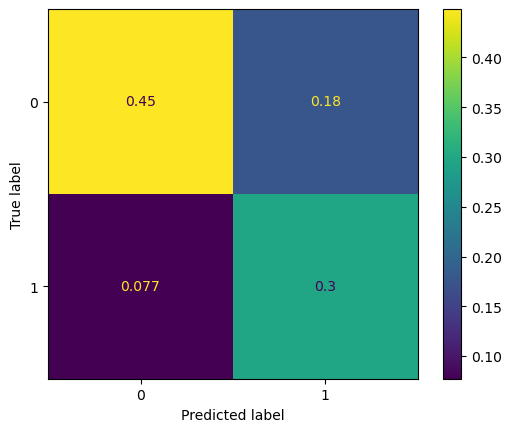

In [73]:
yhat_arr = predict(model_cost2, [X_test_num, X_test_encoded], samples=100)
yhat_mean = np.mean(yhat_arr, axis=1)

confusion_matrix_display(yhat_mean, Y_test, 'Cost-Sensitive Model (MC Dropout):')

2352/2352 [==============================] - 1s 445us/step


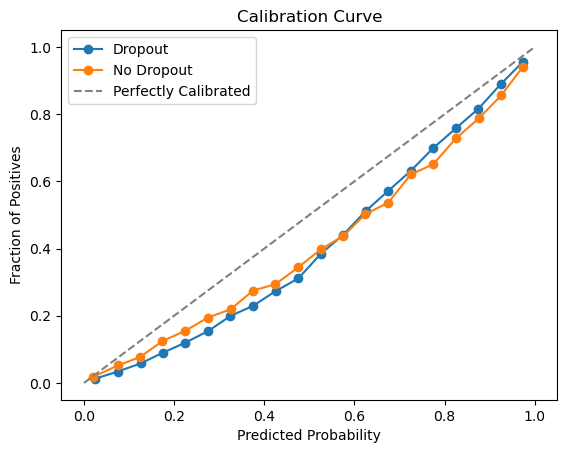

In [81]:
# Calculate calibration curve
prob_true1, prob_pred1 = calibration_curve(Y_test, yhat_mean.reshape(-1,1), n_bins=20)
plt.plot(prob_pred1, prob_true1, marker='o', linestyle='-', label='Dropout')

y_pred = model_cost.predict([X_test_num, X_test_encoded])
prob_true2, prob_pred2 = calibration_curve(Y_test, y_pred, n_bins=20)
plt.plot(prob_pred2, prob_true2, marker='o', linestyle='-', label='No Dropout')

plt.xlabel('Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.legend()

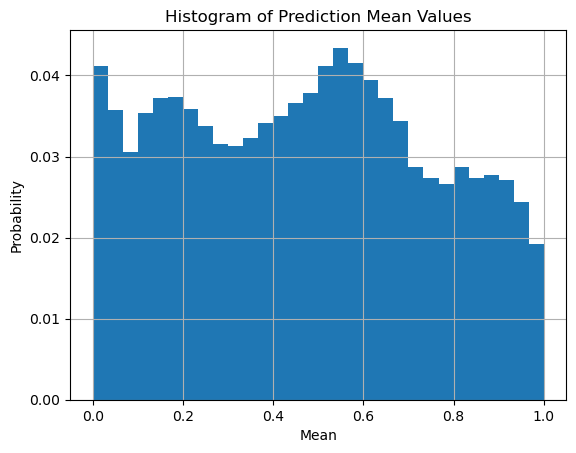

In [80]:
# Plot normalized histogram
hist, bins = np.histogram(yhat_mean, bins=30, density=True)
widths = np.diff(bins)
plt.bar(bins[:-1], hist * widths, width=np.diff(bins), align='edge')
plt.xlabel('Mean')
plt.ylabel('Probability')
plt.title('Histogram of Prediction Mean Values')
plt.grid(True)
plt.show()

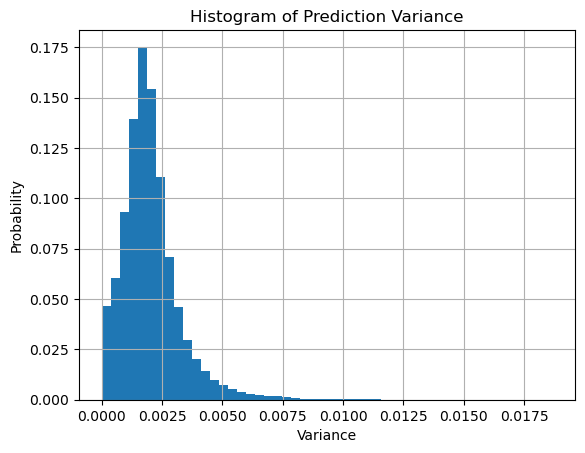

In [83]:
yhat_var = np.var(yhat_arr, axis=1)

# Plot normalized histogram
hist, bins = np.histogram(yhat_var, bins=50, density=True)
widths = np.diff(bins)
plt.bar(bins[:-1], hist * widths, width=np.diff(bins), align='edge')
plt.xlabel('Variance')
plt.ylabel('Probability')
plt.title('Histogram of Prediction Variance')
plt.grid(True)
plt.show()

In [85]:
def threshold_cutoff(y_pred_mean, y_test, y_var):
    sorted_yhat_var = np.sort(y_var)

    proportions = np.linspace(0.1, 1, 30)

    sensitivities = np.zeros(len(proportions))
    specificities = np.zeros(len(proportions))
    aucs = np.zeros(len(proportions))
    accuracies = np.zeros(len(proportions))

    for i in range(len(proportions)):
        index = int(len(sorted_yhat_var) * proportions[i])-1

        thresh = sorted_yhat_var[index]
        indices = y_var < thresh

        Y_test_new = y_test[indices]
        y_pred_new = y_pred_mean[indices]

        tn, fp, fn, tp = confusion_matrix(Y_test_new, y_pred_new > 0.5).ravel()
        
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn +fp)
        auc = roc_auc_score(Y_test_new, y_pred_new)
        accuracy = accuracy_score(Y_test_new, y_pred_new > 0.5)

        sensitivities[i] = sensitivity
        specificities[i] = specificity
        aucs[i] = auc
        accuracies[i] = accuracy

    plt.plot(proportions, sensitivities, label='Sensitivity')
    plt.plot(proportions, specificities, label='Specificity')
    plt.plot(proportions, aucs, label='AUC')
    plt.plot(proportions, accuracies, label='Accuracy', linewidth=2)
    plt.xlabel('Proportion of Test Set Predicted Upon')
    plt.ylabel('Value')
    plt.title('Metrics with Different Variance Cutoffs')
    plt.legend()
    plt.grid(True)  # Add grid
    plt.show()

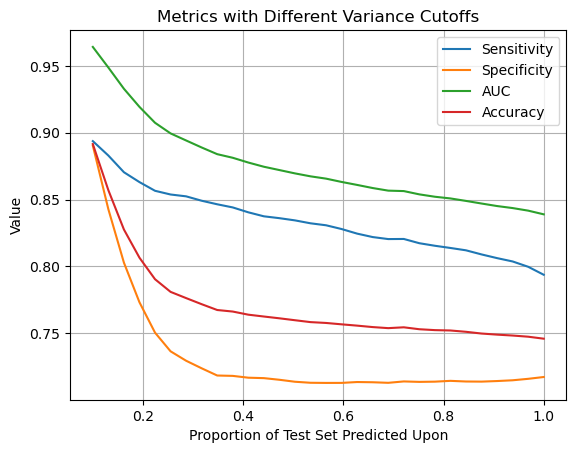

In [86]:
mean_preds = np.mean(yhat_arr, axis=1)
threshold_cutoff(mean_preds, Y_test, yhat_var)

# Expected Calibration Error

In [105]:
# Define the resampling pipeline
resampling_pipeline = Pipeline([
    ('over_sampler', RandomOverSampler(sampling_strategy=0.8)),  # Adjust the sampling strategy as needed
    ('under_sampler', RandomUnderSampler(sampling_strategy=1.0))   # Adjust the sampling strategy as needed
])

# Fit and apply the resampling pipeline to your training data
X_resampled, Y_resampled = resampling_pipeline.fit_resample(X_combined, Y)
Y_resampled = Y_resampled.astype('float32')

In [109]:
models_ece, test_data_ece, test_labels_ece = cross_validate(X_resampled, 
                                                Y_resampled,
                                                num_folds=5,
                                                epochs=10,
                                                batch_size=100,
                                                loss=binary_expected_calibration_error,
                                                )

y_pred_list_ece, y_test_list_ece, _ = evaluate_models(models_ece, test_data_ece, test_labels_ece, mc_dropout=False)

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
2363/2363 [==============================] - 1s 458us/step


   1/2363 [..............................] - ETA: 46s

2363/2363 [==============================] - 1s 496us/step

 Calibrated Model with Balanced Dataset:
Accuracy: 73.83%
Sensitivity: 0.746
Specificity: 0.731
AUC: 0.8189
2363/2363 [==============================] - 1s 454us/step

 Calibrated Model with Balanced Dataset:
Accuracy: 73.47%
Sensitivity: 0.765
Specificity: 0.705
AUC: 0.8124
2363/2363 [==============================] - 1s 453us/step

 Calibrated Model with Balanced Dataset:
Accuracy: 74.06%
Sensitivity: 0.753
Specificity: 0.729
AUC: 0.8199
2363/2363 [==============================] - 1s 448us/step

 Calibrated Model with Balanced Dataset:
Accuracy: 74.07%
Sensitivity: 0.754
Specificity: 0.728
AUC: 0.8219
2363/2363 [==============================] - 1s 457us/step

 Calibrated Model with Balanced Dataset:
Accuracy: 72.98%
Sensitivity: 0.726
Specificity: 0.733
AUC: 0.8057


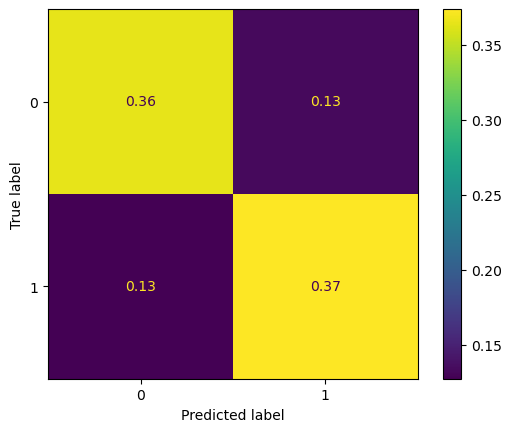

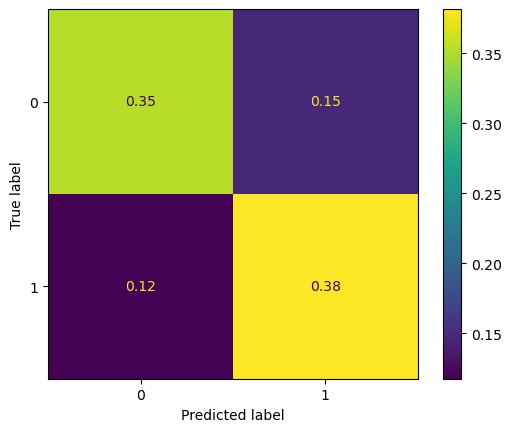

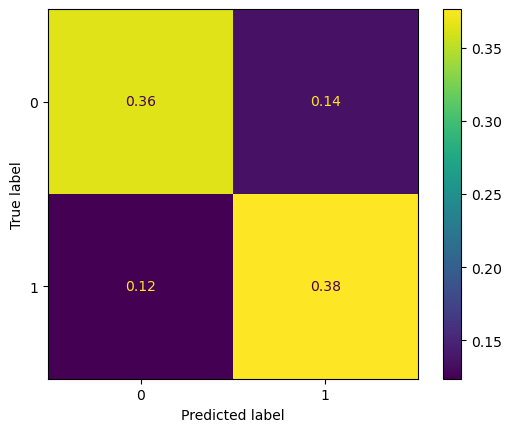

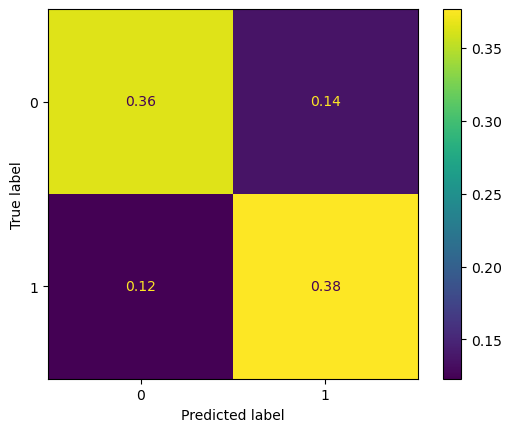

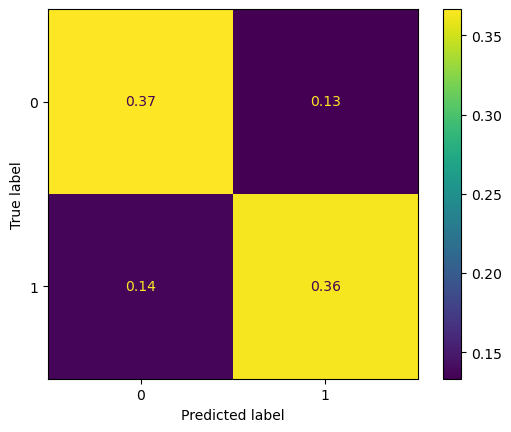

In [110]:
for i in range(len(models_ece)):
    y_pred = models_ece[i].predict(test_data_ece[i])
    confusion_matrix_display(y_pred, test_labels_ece[i], 'Calibrated Model with Balanced Dataset:')

2363/2363 [==============================] - 1s 496us/step


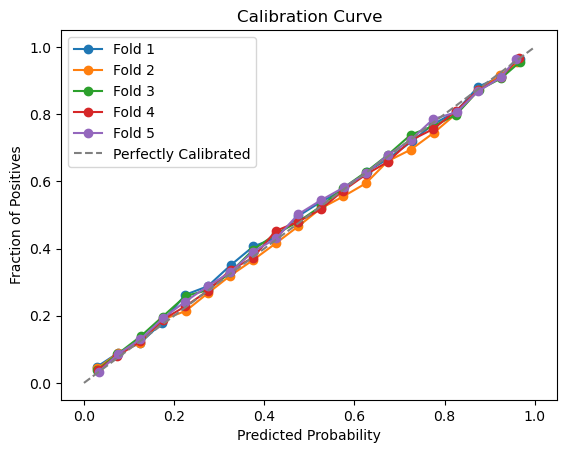

In [117]:
# Calculate calibration curve
for i in range(len(models_ece)):
    y_pred = models_ece[i].predict(test_data_ece[i])
    prob_true1, prob_pred1 = calibration_curve(test_labels_ece[i], y_pred, n_bins=20)
    plt.plot(prob_pred1, prob_true1, marker='o', linestyle='-', label=f'Fold {i+1}')

plt.xlabel('Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.legend()

As we can see we get a much more accurate model, while only sacrificing overall accuracy by about 2%

2363/2363 [==============================] - 2s 641us/step


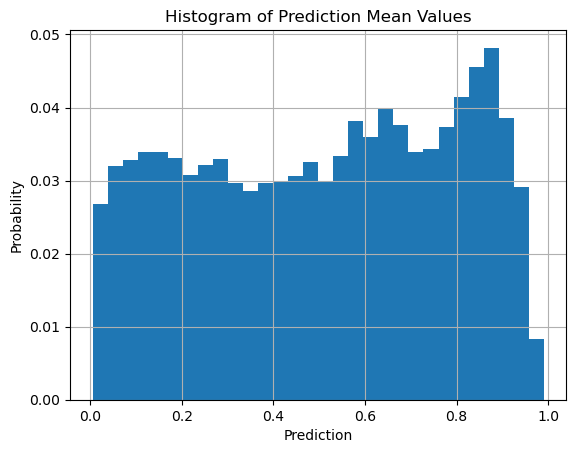

In [119]:
# Plot normalized histogram
hist, bins = np.histogram(models_ece[1].predict(test_data_ece[1]), bins=30, density=True)
widths = np.diff(bins)
plt.bar(bins[:-1], hist * widths, width=np.diff(bins), align='edge')
plt.xlabel('Prediction')
plt.ylabel('Probability')
plt.title('Histogram of Prediction Mean Values')
plt.grid(True)
plt.show()

In [151]:
def threshold_cutoff_calibration(y_pred, y_test, cutoffs, title='Metrics with Different Variance Cutoffs'):
    proportions = np.zeros((len(cutoffs)))

    sensitivities = np.zeros(len(cutoffs))
    specificities = np.zeros(len(cutoffs))
    aucs = np.zeros(len(cutoffs))
    accuracies = np.zeros(len(cutoffs))

    for i in range(len(cutoffs)):
        lower_value = 0 + cutoffs[i]
        upper_value = 1 - cutoffs[i]
        
        proportions[i] = (y_pred[y_pred < lower_value].shape[0]+y_pred[y_pred >= upper_value].shape[0])/y_pred.shape[0]
        
        
        ind1 = y_pred < lower_value
        ind2 = y_pred >= upper_value

        mask = np.zeros_like(y_pred, dtype=bool)
        mask[ind1] = True
        mask[ind2] = True
        mask = mask.squeeze()

        preds_to_test = y_pred[mask]
        test_labels = y_test[mask]

        tn, fp, fn, tp = confusion_matrix(test_labels, preds_to_test > 0.5).ravel()
        
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn +fp)
        auc = roc_auc_score(test_labels, preds_to_test)
        accuracy = accuracy_score(test_labels, preds_to_test > 0.5)

        sensitivities[i] = sensitivity
        specificities[i] = specificity
        aucs[i] = auc
        accuracies[i] = accuracy

    plt.plot(proportions, accuracies, label='Accuracy')
    plt.plot(proportions, sensitivities, label='Sensitivity')
    plt.plot(proportions, specificities, label='Specificity')
    plt.plot(proportions, aucs, label='AUC')
    
    plt.xlabel('Proportion of Test Set Predicted Upon')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)  # Add grid
    plt.show()

2363/2363 [==============================] - 1s 491us/step


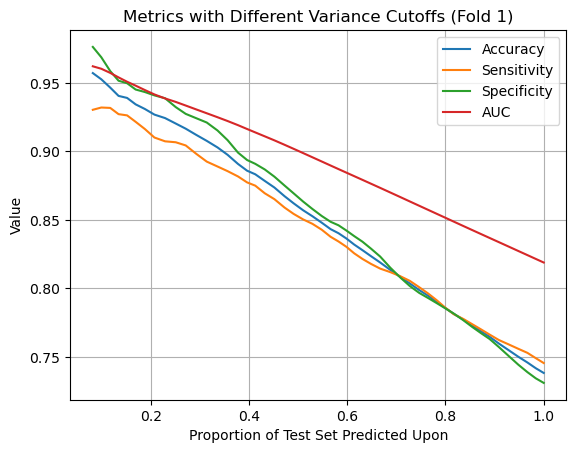

2363/2363 [==============================] - 1s 524us/step


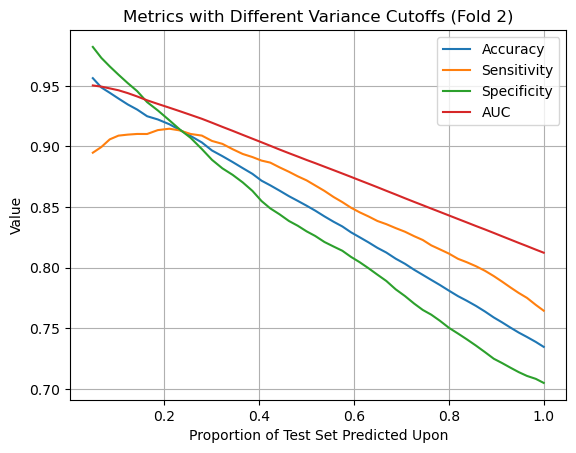

2363/2363 [==============================] - 1s 573us/step


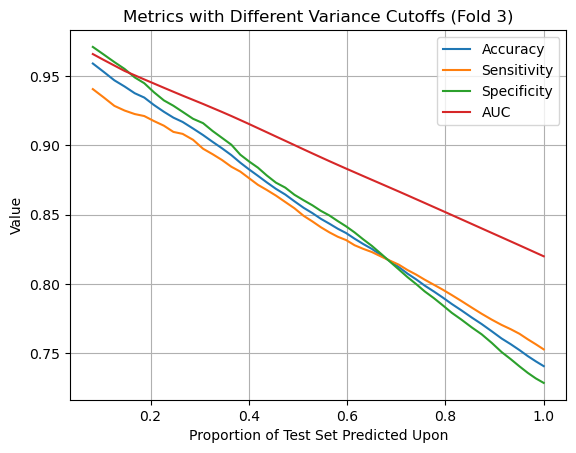

2363/2363 [==============================] - 1s 536us/step


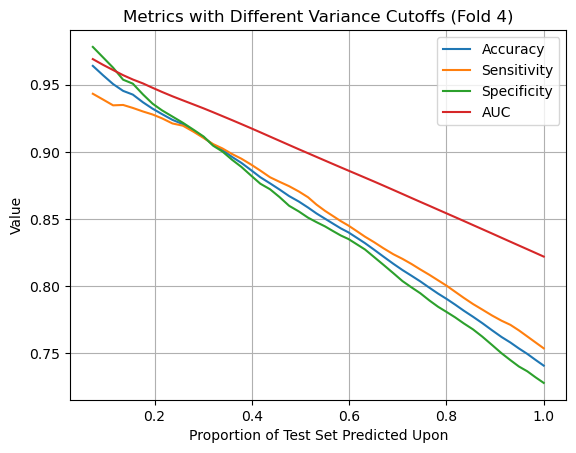

2363/2363 [==============================] - 1s 493us/step


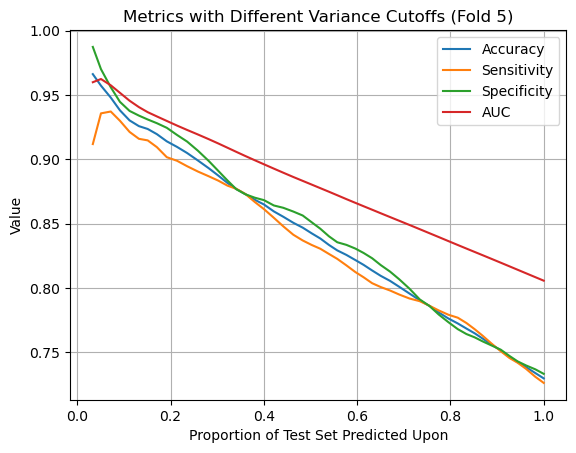

In [150]:
for i in range(5):
    num = i
    pred = models_ece[num].predict(test_data_ece[num])
    test_labels = test_labels_ece[num]

    cutoffs = np.linspace(0.05, 0.5)

    threshold_cutoff_calibration(pred, test_labels, cutoffs, title=f'Metrics with Different Variance Cutoffs (Fold {i+1})')